In [1]:
import os
import sys
import time
import shutil
import pickle

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

%matplotlib inline

from sklearn.metrics import f1_score
from tensorflow import keras
from tensorflow.keras import layers, models

import sklearn.preprocessing
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

2024-10-01 10:49:45.101760: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-01 10:49:45.136272: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-01 10:49:45.136307: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-01 10:49:45.137171: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-01 10:49:45.143791: I tensorflow/core/platform/cpu_feature_guar

In [2]:
print(tf.__version__)
print(tf.config.list_physical_devices())

2.15.0
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2024-10-01 10:49:47.473988: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-10-01 10:49:47.513636: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-10-01 10:49:47.513687: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [3]:
# gpus = tf.config.list_physical_devices('GPU')
# if gpus:
#   try:
#     # Currently, memory growth needs to be the same across GPUs
#     for gpu in gpus:
#       tf.config.experimental.set_memory_growth(gpu, True)
#     logical_gpus = tf.config.list_logical_devices('GPU')
#     print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
#   except RuntimeError as e:
#     # Memory growth must be set before GPUs have been initialized
#     print(e)

# gpus = tf.config.experimental.list_physical_devices('GPU')
# if gpus:
#     try:
#         for gpu in gpus:
#             tf.config.experimental.set_virtual_device_configuration(
#                 gpu,
#                 [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4096)])  # Set your memory limit here
#     except RuntimeError as e:
#         print(e)

In [4]:
def get_dataset(directory, single_file=False, use_half=False, section=1, use_num_files=False, num_files=100):  
    if single_file:
        df = pd.read_csv(directory, index_col='timestamp')
        df.dropna(inplace=True)
        return df
    
    merged_df = pd.DataFrame()
    list_files = os.listdir(directory)
    print(len(list_files))
    if use_num_files:
        for i in range(num_files):
            df = pd.read_csv(os.path.join(directory, list_files[i]), index_col='timestamp')
            df.dropna(inplace=True)
            merged_df = pd.concat([merged_df, df], ignore_index=True)

    if use_half:
        for i, files in enumerate(list_files):
            if section==1:
                if i > len(list_files) //2:
                    continue
                df = pd.read_csv(os.path.join(directory, files), index_col='timestamp')
                df.dropna(inplace=True)
                merged_df = pd.concat([merged_df, df], ignore_index=True)
            if section==2:
                if i <= len(list_files) // 2:
                    continue
                df = pd.read_csv(os.path.join(directory, files), index_col='timestamp')
                df.dropna(inplace=True)
                merged_df = pd.concat([merged_df, df], ignore_index=True)
    else:
        for files in list_files:
            df = pd.read_csv(os.path.join(directory, files), index_col='timestamp')
            df.dropna(inplace=True)
            merged_df = pd.concat([merged_df, df], ignore_index=True)
    
    # print(i)
    return merged_df

In [5]:
def convert_time_window(data, timesteps):
    samples = data.shape[0] - timesteps + 1  # Number of samples in the new 3D array
    variables = data.shape[1]  # Number of variables (features)

    data_3d = np.zeros((samples, timesteps, variables), dtype='float32')

    for i in range(samples):
        data_3d[i] = data[i:i+timesteps]
    return data_3d

In [6]:
def inverse_convert_time_window(data_3d):
    samples, timesteps, variables = data_3d.shape
    data_2d = np.zeros((samples + timesteps - 1, variables))

    count = np.zeros((samples + timesteps - 1, variables))

    for i in range(samples):
        data_2d[i:i+timesteps] += data_3d[i]
        count[i:i+timesteps] += 1

    # Average the overlapping segments
    data_2d /= count
    return data_2d

In [7]:
# def calculate_reconstruction_loss(data, reconstructions):
#     reconstruction_errors = np.mean(np.square(data - reconstructions), axis=1)
#     total_r_e = np.sum(reconstruction_errors)
#     relative_reconstruction_errors = np.array([(r_e / total_r_e) * 100 for r_e in reconstruction_errors])
#     return relative_reconstruction_errors

def calculate_reconstruction_loss(data, reconstructions):
    reconstruction_errors = np.mean(np.abs(data - reconstructions), axis=1)
    total_r_e = np.sum(reconstruction_errors)
    max_r_e = np.max(reconstruction_errors)
    relative_reconstruction_errors = np.array([(r_e / total_r_e) * 100 for r_e in reconstruction_errors])
    return reconstruction_errors

In [8]:
def find_optimal_threshold(reconstruction_errors, y_true):
    from sklearn.metrics import accuracy_score, balanced_accuracy_score

    best_threshold = 0.0
    best_f1 = 0.0
    best_y_pred = np.zeros(reconstruction_errors.shape)
    # q3 = np.percentile(reconstruction_errors, 75)
    # q1 = np.percentile(reconstruction_errors, 25)
    # iqr = q3 - q1
    upper_bound = np.max(reconstruction_errors)
    lower_bound = np.min(reconstruction_errors)

    thresholds = np.linspace(lower_bound, upper_bound, num=500)

    for threshold in thresholds:
        y_pred = np.where((reconstruction_errors > threshold) ,1, 0)
        # print(y_pred.shape)
        # print(y_true.shape)

        # Hitung F1-Score
        current_f1 = balanced_accuracy_score(y_true.astype(bool), y_pred.astype(bool))

        if current_f1 > best_f1:
            best_f1 = current_f1
            best_threshold = threshold
            best_y_pred = y_pred

    return best_threshold, best_f1, best_y_pred

In [9]:
# def find_optimal_threshold(reconstruction_errors, y_true):
#     from sklearn.metrics import accuracy_score, balanced_accuracy_score

#     best_threshold = 0.0
#     best_f1 = 0.0
#     best_y_pred = np.zeros(reconstruction_errors.shape)
#     q3 = np.percentile(reconstruction_errors, 75)
#     q1 = np.percentile(reconstruction_errors, 25)
#     iqr = q3 - q1
#     upper_bound = max(np.max(reconstruction_errors) / 2, (q3 + iqr * 1.5))
#     lower_bound = min(np.min(reconstruction_errors) / 2, (q1 - iqr * 1.5))

#     thresholds = np.linspace(lower_bound, upper_bound, num=500)

#     for threshold in thresholds:
#         y_pred = np.where(
#             (reconstruction_errors > (threshold + iqr)) | 
#             (reconstruction_errors < (threshold - iqr)),
#               1, 0)
#         # print(y_pred.shape)
#         # print(y_true.shape)

#         # Hitung F1-Score
#         current_f1 = balanced_accuracy_score(y_true.astype(bool), y_pred.astype(bool))

#         if current_f1 > best_f1:
#             best_f1 = current_f1
#             best_threshold = threshold
#             best_y_pred = y_pred

#     return best_threshold, best_f1, best_y_pred

## Training

In [10]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import pickle

df = pd.read_csv("../../datasets/turbine-gas-gearbox/BLD-LGC PTGBX 26 JUL21-8FEB23_edited.csv", index_col='Timestamp')

scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)
pickle.dump(scaler, open('StandardScaler-gearbox.pkl', 'wb'))

<Axes: >

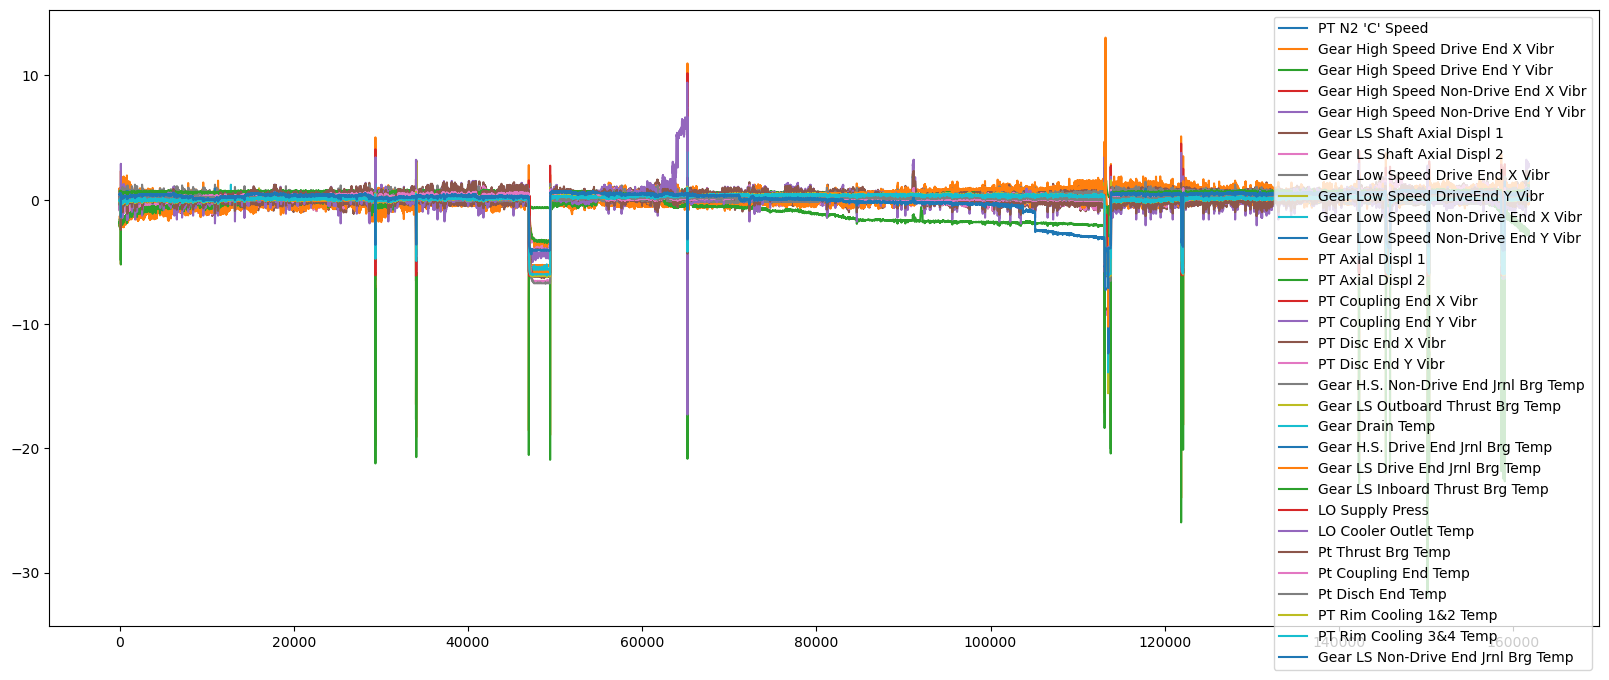

In [11]:
pd.DataFrame(df_scaled, columns=df.columns).plot(figsize=(20,8))

In [12]:
df.shape
# if 'Gear LS Inboard Thrust Brg Temp' in df.columns:
#     df.drop('Gear LS Inboard Thrust Brg Temp', axis=1, inplace=True)

(161788, 31)

In [13]:
df_sample = df.reset_index().loc[:60000-1]
df_sample.to_csv("../../datasets/turbine-gas-gearbox/data_sample.csv", index=False)

In [14]:
df_sample_test = df.reset_index().loc[60000:70000-1]
df_sample_test.to_csv("../../datasets/turbine-gas-gearbox/data_sample_test.csv", index=False)

In [15]:
df_sample = pd.read_csv("../../datasets/turbine-gas-gearbox/data_sample.csv", index_col="Timestamp")
print(df_sample.shape)

(60000, 31)


In [16]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import pickle

# scaler = MinMaxScaler([0,1])
scaler = pickle.load(open('StandardScaler-gearbox.pkl', 'rb'))
df_sample_scaled = scaler.transform(df_sample)

[]

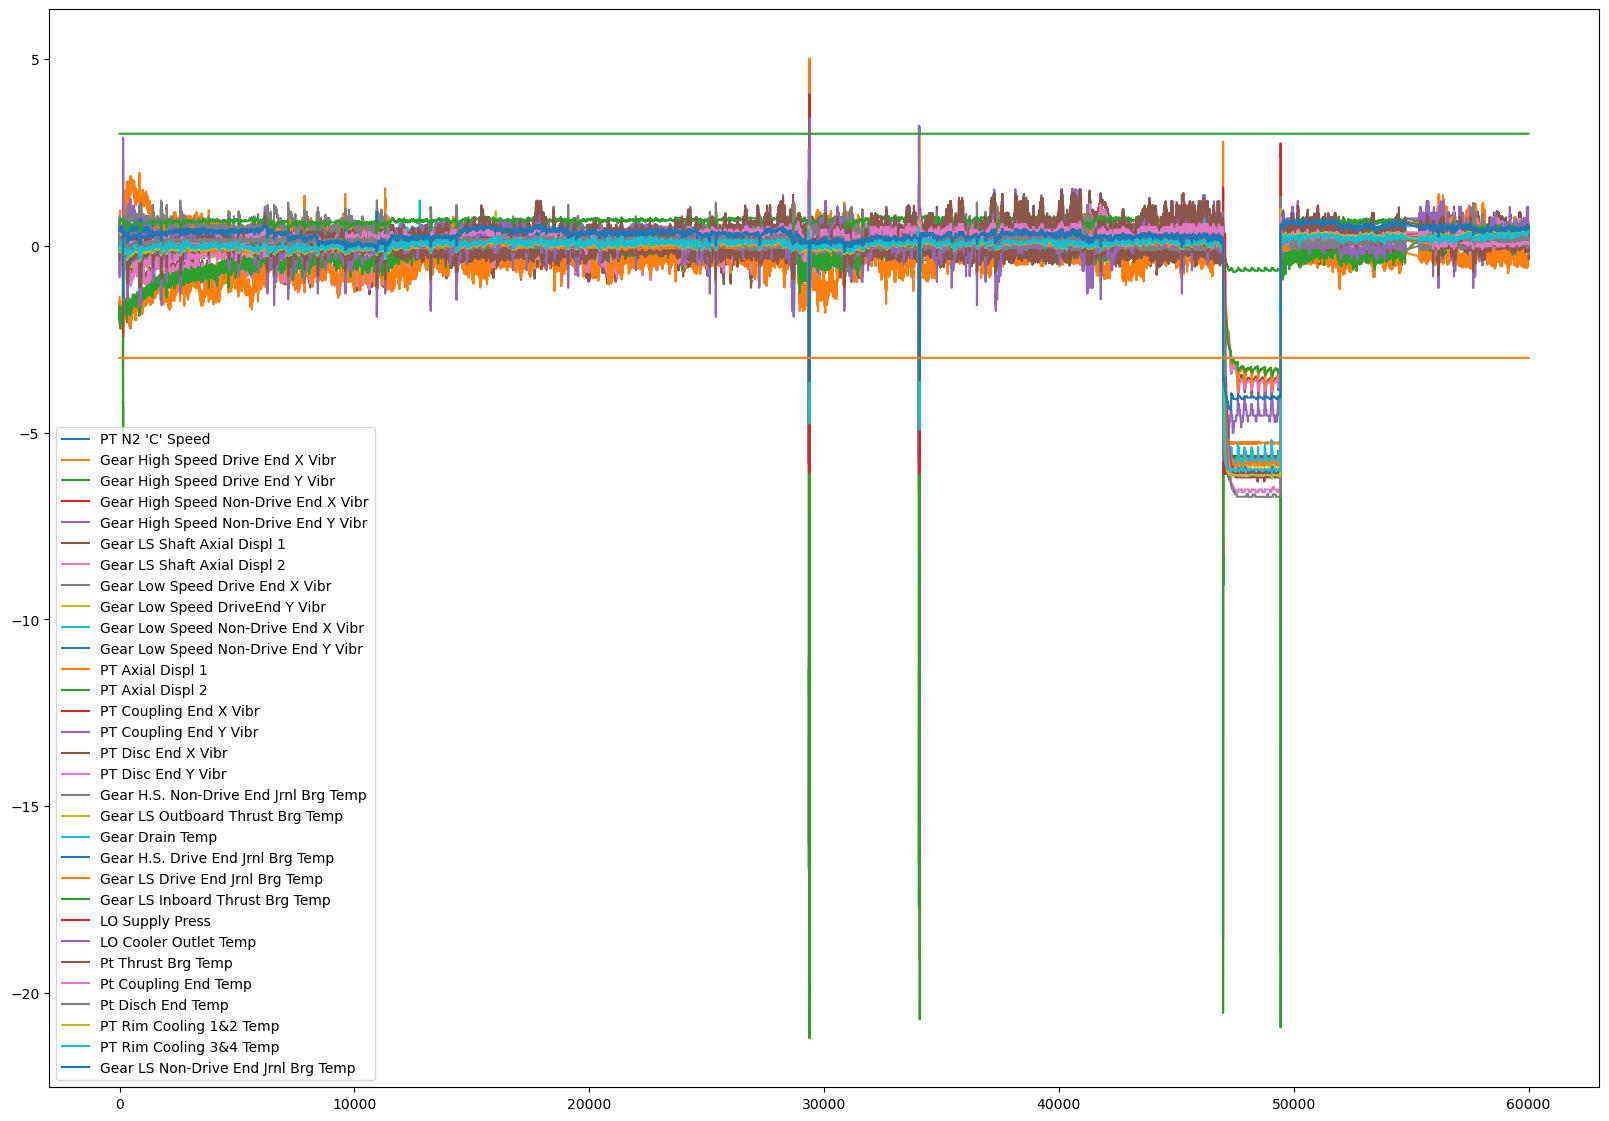

In [17]:
plt.figure(figsize=(20,14))
plt.plot(df_sample_scaled)
plt.plot(np.full(df_sample_scaled.shape[0], -3))
plt.plot(np.full(df_sample_scaled.shape[0], 3))
plt.legend(df_sample.columns)
plt.plot()

In [18]:
df_sample['label'] = np.where(np.any((df_sample_scaled < -3) | (df_sample_scaled > 3), axis=1), 1, 0)

[]

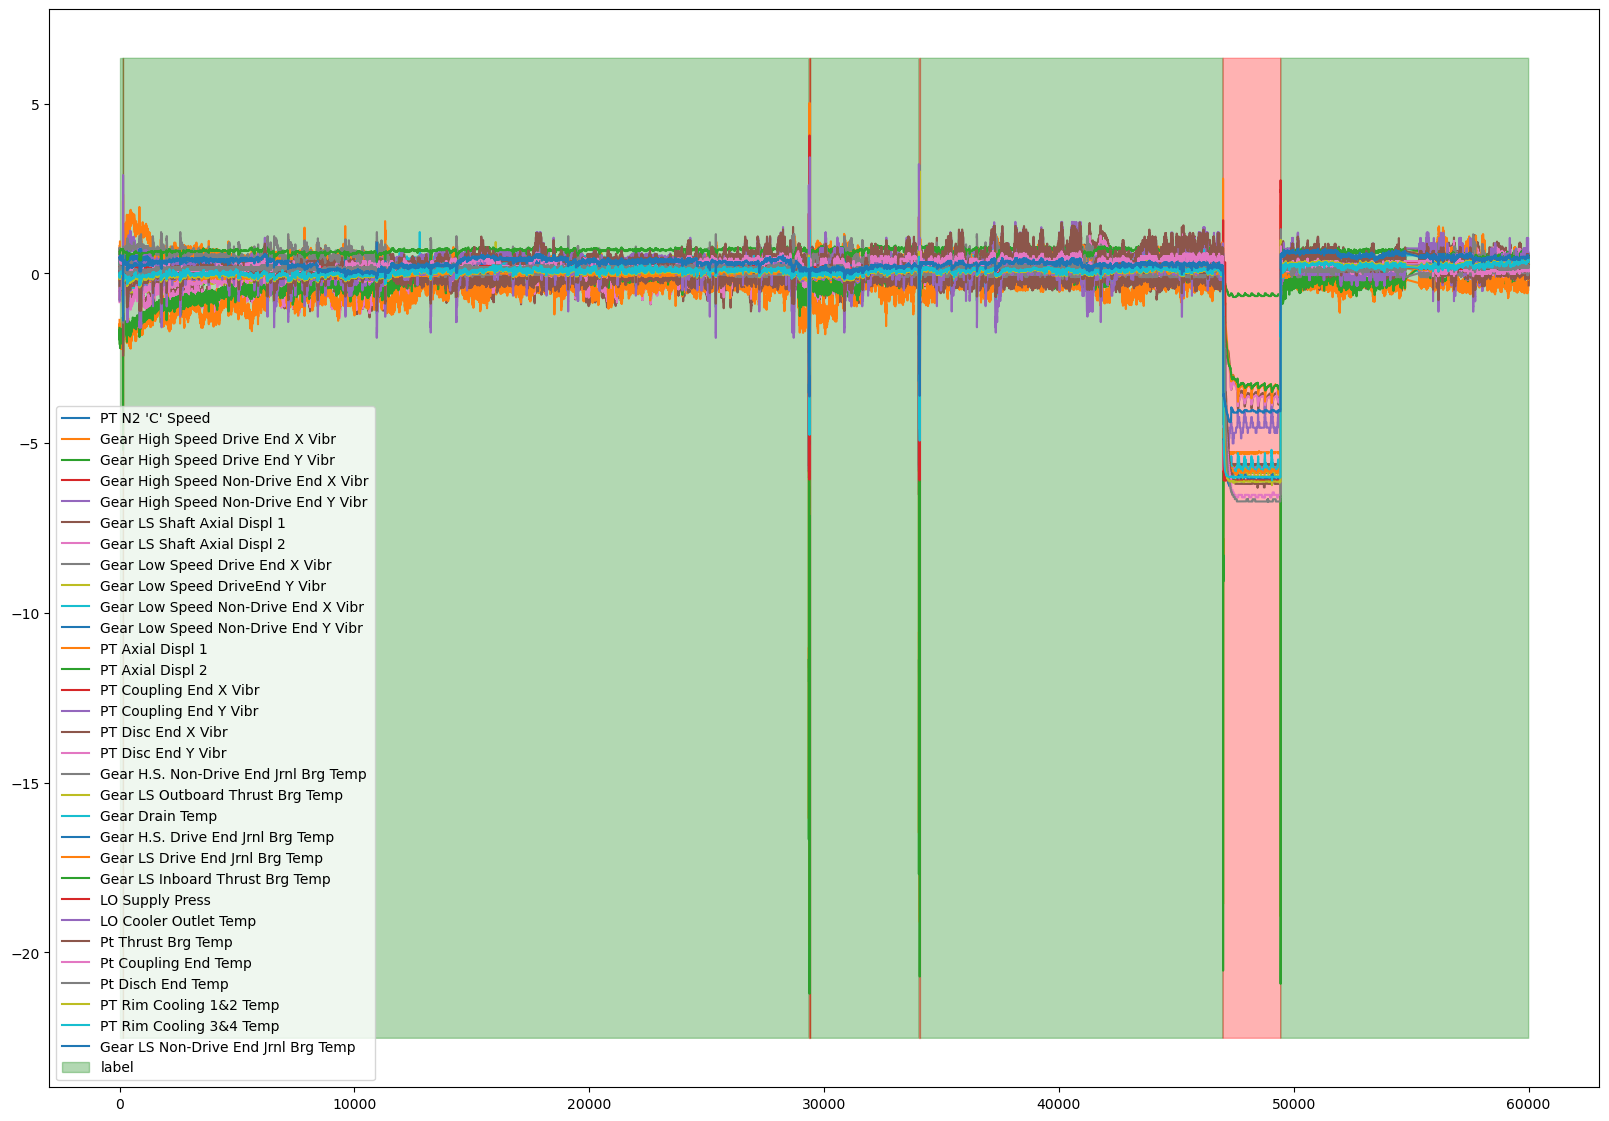

In [19]:
plt.figure(figsize=(20,14))
plt.plot(df_sample_scaled)
xmin, xmax, ymin, ymax = plt.axis()
plt.fill_between(np.arange(0, df_sample_scaled.shape[0]), ymin, ymax, where=(df_sample['label'] == 0), color='green', alpha=0.3)
plt.fill_between(np.arange(0, df_sample_scaled.shape[0]), ymin, ymax, where=(df_sample['label'] == 1), color='red', alpha=0.3)
plt.legend(df_sample.columns)
plt.plot()

In [20]:
df_sample.loc[df_sample['label'] == 0,:].shape

(57449, 32)

In [21]:
df_sample_scaled = scaler.transform(df_sample.loc[df_sample['label'] == 0,:].drop("label", axis=1))

[]

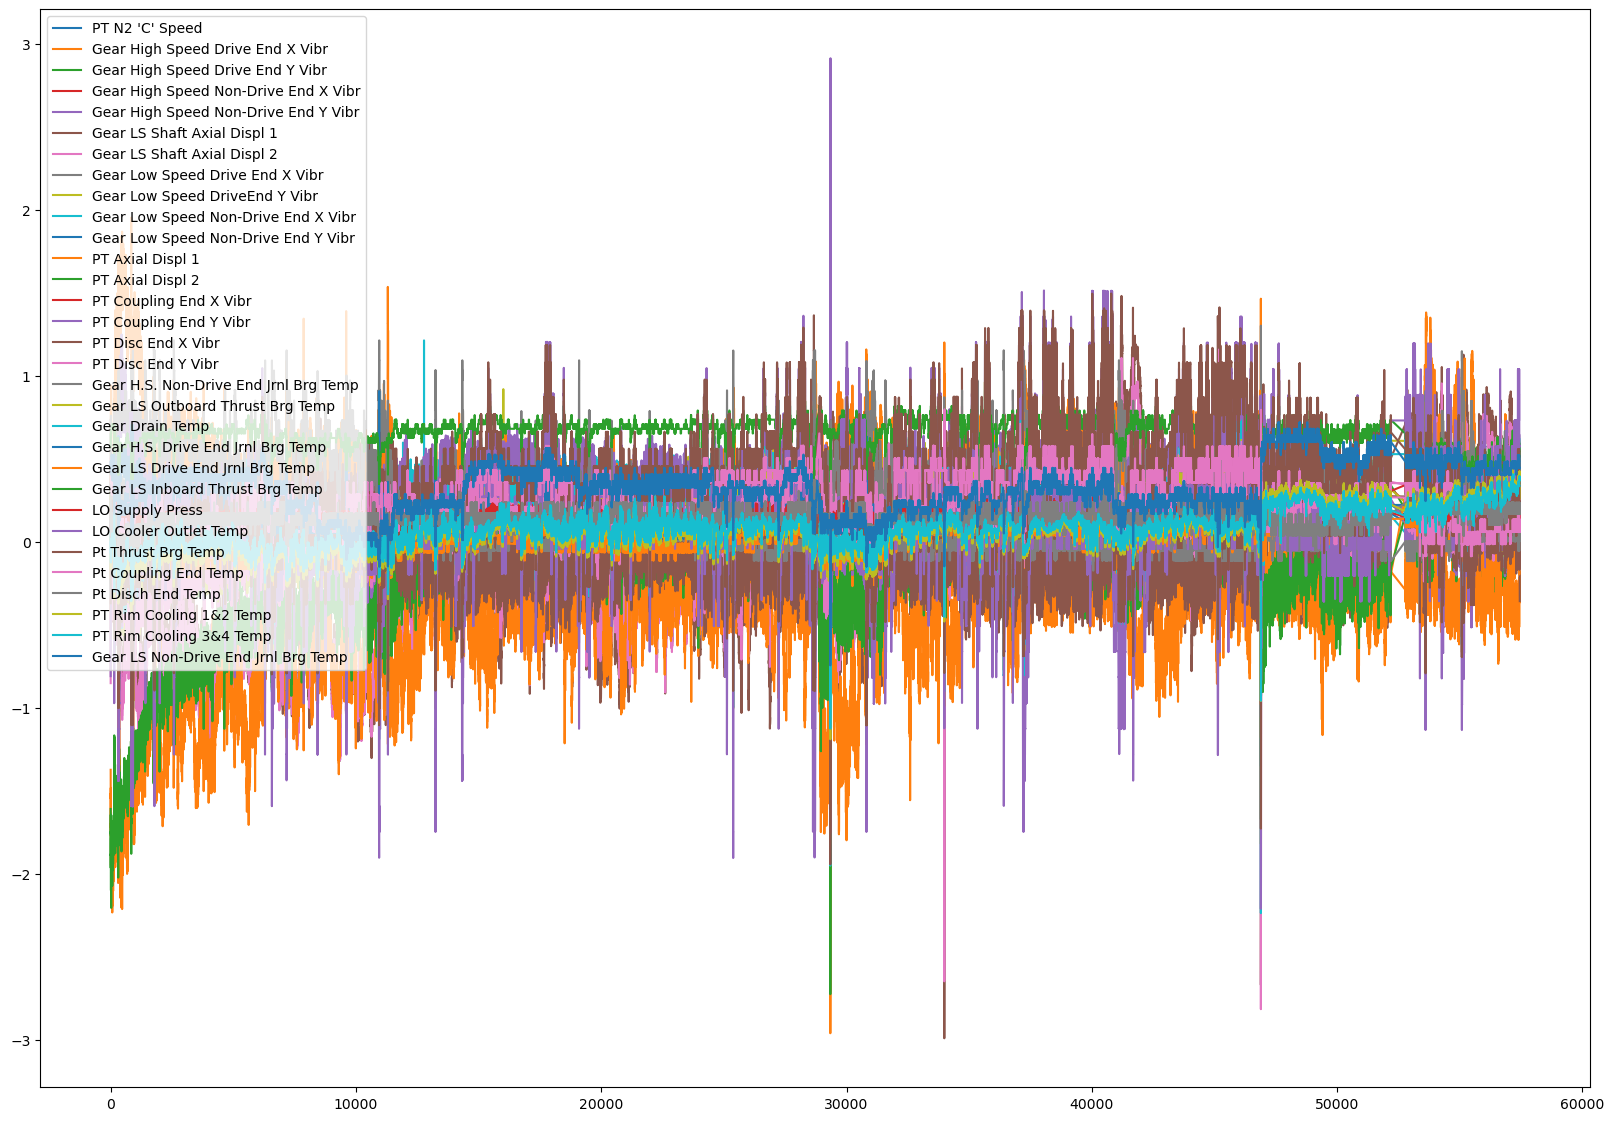

In [22]:
plt.figure(figsize=(20,14))
plt.plot(df_sample_scaled)
plt.legend(df_sample.columns)
plt.plot()

In [23]:
df_sample_scaled_3d = convert_time_window(df_sample_scaled, 10)

In [24]:
tf_dataset_path = "../../datasets/dataset_processed/tf_data/LSTM-GAN/gearbox" 

dataset = tf.data.Dataset.from_tensor_slices(df_sample_scaled_3d)
dataset = dataset.batch(64)
tf.data.Dataset.save(dataset, tf_dataset_path)

2024-10-01 10:50:22.496403: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-10-01 10:50:22.496518: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-10-01 10:50:22.496545: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-10-01 10:50:22.742379: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-10-01 10:50:22.742523: I external/local_xla/xla/stream_executor

## ==================================================

In [25]:
def build_encoder(input_shape):
    input_layer = layers.Input(shape=input_shape)
    encoder = layers.LSTM(128, return_sequences=True)(input_layer)
    encoder = layers.LSTM(64, return_sequences=True)(encoder)
    encoder = layers.LSTM(32)(encoder)
    encoder = layers.Dense(24, activation='relu')(encoder)
    output_layer = layers.Dense(10, activation='relu')(encoder)

    model = keras.models.Model(inputs=input_layer, outputs=output_layer, name="Encoder")    
    return model

def build_decoder(output_shape):
    input_layer = layers.Input(shape=(10,))
    decoder = layers.Dense(24, activation='relu')(input_layer)
    decoder = layers.Dense(24, activation='relu')(decoder)
    decoder = layers.RepeatVector(output_shape[0])(decoder)

    decoder = layers.LSTM(32, return_sequences=True)(decoder)
    decoder = layers.LSTM(64, return_sequences=True)(decoder)
    decoder = layers.LSTM(128, return_sequences=True)(decoder)

    output_layer = layers.TimeDistributed(layers.Dense(output_shape[1]))(decoder)
    model = keras.models.Model(inputs=input_layer, outputs=output_layer, name="Decoder")
    
    return model

def build_discriminator(input_shape):
    input_layer = layers.Input(shape=input_shape)
    encoder = layers.LSTM(128, return_sequences=True)(input_layer)
    encoder = layers.LSTM(64, return_sequences=True)(encoder)
    encoder = layers.LSTM(32)(encoder)
    encoder = layers.Dense(24, activation='relu')(encoder)
    encoder = layers.Dense(10, activation='relu')(encoder)
    output_layer = layers.Dense(1, activation='sigmoid')(encoder)
    
    model = keras.models.Model(inputs=input_layer, outputs=output_layer, name="Discriminator")

    return model

In [26]:
class Generator(models.Model):
    def __init__(self, input_shape, output_shape):
        super(Generator, self).__init__()
        self.encoder = build_encoder(input_shape)
        self.decoder = build_decoder(output_shape)

    def call(self, x):
        z = self.encoder(x)
        reconstructed_x = self.decoder(z)
        return reconstructed_x


In [27]:
# L1 norm for lx
def reconstruction_loss_lx(x, generated_x):
    return tf.reduce_mean(tf.abs(x - generated_x))

# L2 norm for lz
def reconstruction_loss_lz(z_enc1, z_enc2):
    return tf.reduce_mean(tf.square(z_enc1 - z_enc2))

# Adversarial loss for generator
def adversarial_loss(disc_output_gen):
    return tf.keras.losses.BinaryCrossentropy()(tf.ones_like(disc_output_gen), disc_output_gen)

# Total Generator loss
def generator_loss(x, generated_x, z_enc1, z_enc2, disc_output_gen, w1, w2, w3):
    x = tf.cast(x, tf.float16)
    generated_x = tf.cast(generated_x, tf.float16)
    z_enc1 = tf.cast(z_enc1, tf.float16)
    z_enc2 = tf.cast(z_enc2, tf.float16)
    disc_output_gen = tf.cast(disc_output_gen, tf.float16)

    lx = reconstruction_loss_lx(x, generated_x)
    lz = reconstruction_loss_lz(z_enc1, z_enc2)
    ladv = adversarial_loss(disc_output_gen)
    return w1 * lx + w2 * lz + w3 * ladv

# Discriminator loss
def discriminator_loss(real_output, fake_output):
    real_loss = tf.keras.losses.BinaryCrossentropy()(tf.ones_like(real_output), real_output)
    fake_loss = tf.keras.losses.BinaryCrossentropy()(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

In [28]:
# Define the input shape
time_window = 10 
features = 31 
input_shape = (time_window, features)

# Define optimizers
gen_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
disc_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-6)

## ================================

In [29]:
# Instantiate models
generator = Generator(input_shape, input_shape)
discriminator = build_discriminator(input_shape)
encoder2 = build_encoder(input_shape)

# Example of compiling the discriminator
discriminator.compile(optimizer=disc_optimizer, loss='binary_crossentropy')
# generator.encoder.compile(optimizer=gen_optimizer, loss=generator_loss)


2024-10-01 10:50:23.394437: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


In [30]:
generator.encoder.summary()

Model: "Encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10, 31)]          0         
                                                                 
 lstm (LSTM)                 (None, 10, 128)           81920     
                                                                 
 lstm_1 (LSTM)               (None, 10, 64)            49408     
                                                                 
 lstm_2 (LSTM)               (None, 32)                12416     
                                                                 
 dense (Dense)               (None, 24)                792       
                                                                 
 dense_1 (Dense)             (None, 10)                250       
                                                                 
Total params: 144786 (565.57 KB)
Trainable params: 144786 (

In [31]:
generator.decoder.summary()

Model: "Decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 10)]              0         
                                                                 
 dense_2 (Dense)             (None, 24)                264       
                                                                 
 dense_3 (Dense)             (None, 24)                600       
                                                                 
 repeat_vector (RepeatVecto  (None, 10, 24)            0         
 r)                                                              
                                                                 
 lstm_3 (LSTM)               (None, 10, 32)            7296      
                                                                 
 lstm_4 (LSTM)               (None, 10, 64)            24832     
                                                           

In [32]:
encoder2.summary()

Model: "Encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 10, 31)]          0         
                                                                 
 lstm_9 (LSTM)               (None, 10, 128)           81920     
                                                                 
 lstm_10 (LSTM)              (None, 10, 64)            49408     
                                                                 
 lstm_11 (LSTM)              (None, 32)                12416     
                                                                 
 dense_8 (Dense)             (None, 24)                792       
                                                                 
 dense_9 (Dense)             (None, 10)                250       
                                                                 
Total params: 144786 (565.57 KB)
Trainable params: 144786 (

In [33]:
discriminator.summary()

Model: "Discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 10, 31)]          0         
                                                                 
 lstm_6 (LSTM)               (None, 10, 128)           81920     
                                                                 
 lstm_7 (LSTM)               (None, 10, 64)            49408     
                                                                 
 lstm_8 (LSTM)               (None, 32)                12416     
                                                                 
 dense_5 (Dense)             (None, 24)                792       
                                                                 
 dense_6 (Dense)             (None, 10)                250       
                                                                 
 dense_7 (Dense)             (None, 1)               

## ===================================

In [34]:
# # Use when retraining existing models
generator = Generator(input_shape, input_shape)
generator.encoder = tf.keras.models.load_model("../../models/LSTM-GAN/gearbox/generator-encoder.h5")
generator.decoder = tf.keras.models.load_model("../../models/LSTM-GAN/gearbox/generator-decoder.h5")

encoder2 = tf.keras.models.load_model("../../models/LSTM-GAN/gearbox/encoder2.h5")
discriminator = tf.keras.models.load_model("../../models/LSTM-GAN/gearbox/discriminator.h5")

In [35]:
generator.encoder.summary()

Model: "Encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10, 31)]          0         
                                                                 
 lstm (LSTM)                 (None, 10, 128)           81920     
                                                                 
 lstm_1 (LSTM)               (None, 10, 64)            49408     
                                                                 
 lstm_2 (LSTM)               (None, 32)                12416     
                                                                 
 dense (Dense)               (None, 24)                792       
                                                                 
 dense_1 (Dense)             (None, 10)                250       
                                                                 
Total params: 144786 (565.57 KB)
Trainable params: 144786 (

## ====================================

In [36]:
tf_dataset_path = "../../datasets/dataset_processed/tf_data/LSTM-GAN/gearbox"
dataset = tf.data.Dataset.load(tf_dataset_path)

In [37]:
# Prefetch for performance optimization
with tf.device('/GPU:0'):
    data_loader = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

In [38]:
# def generate_random_noise(batch_size, time_window, features):
#     return tf.random.normal(shape=(batch_size, time_window, features))

In [40]:
import warnings
warnings.filterwarnings('ignore')

epochs = 20  # Example number of epochs
w1 = 0.1
w2 = 0.3
w3 = 0.6

# Use @tf.function to compile functions involving gradient operations
@tf.function
def train_discriminator(batch, generator, discriminator, disc_optimizer):
    with tf.GradientTape() as disc_tape:
        real_output = discriminator(tf.convert_to_tensor(batch))  # Discriminator evaluates real data
        generated_x = generator(tf.convert_to_tensor(batch))
        fake_output = discriminator(generated_x)  # Discriminator evaluates generated data
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    disc_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    return disc_loss

@tf.function
def train_generator(batch, generator, encoder2, discriminator, gen_optimizer, w1, w2, w3):
    with tf.GradientTape() as gen_tape:
        generated_x = generator(tf.convert_to_tensor(batch))  # Generator produces data from noise
        fake_output_gen = discriminator(generated_x)  # Discriminator evaluates generated data
        
        # Since we're training the generator, we compare the generated data against real data
        z_enc1 = generator.encoder(tf.convert_to_tensor(batch))  # Encoder1 with real data
        z_enc2 = encoder2(generated_x)  # Encoder2 with generated data
        
        gen_loss = generator_loss(batch, generated_x, z_enc1, z_enc2, fake_output_gen, w1, w2, w3)
    
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gen_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    return gen_loss

# Training loop
for epoch in range(epochs):
    gen_loss_total = 0
    disc_loss_total = 0
    num_batches = 0

    for batch in data_loader:
        batch_size = np.array(batch).shape[0]  
        num_batches += 1

        # Train the discriminator and generator
        disc_loss = train_discriminator(batch, generator, discriminator, disc_optimizer)
        gen_loss = train_generator(batch, generator, encoder2, discriminator, gen_optimizer, w1, w2, w3)
        
        if np.isnan(gen_loss.numpy()) or np.isnan(disc_loss.numpy()):
            print(f"[{num_batches}]: GENERATOR LOSS AND DISCRIMINATOR LOSS BECOME NaN. End train process...")
            break
        
        gen_loss_total += gen_loss.numpy()
        disc_loss_total += disc_loss.numpy()

        if num_batches % 100 == 0:
            print(f'[{num_batches}]: \tloss_g: {gen_loss}, loss_d: {disc_loss}')
            generator.encoder.save(f"../../models/3W/LSTM-GAN/gearbox/generator-encoder_E{epoch+1}.h5")
            generator.decoder.save(f"../../models/3W/LSTM-GAN/gearbox/generator-decoder_E{epoch+1}.h5")
            encoder2.save(f"../../models/3W/LSTM-GAN/gearbox/encoder2_E{epoch+1}.h5")
            discriminator.save(f"../../models/3W/LSTM-GAN/gearbox/discriminator_E{epoch+1}.h5")

    avg_gen_loss = gen_loss_total / num_batches
    avg_disc_loss = disc_loss_total / num_batches

    print(f'Epoch {epoch+1}/{epochs}, Generator Loss: {avg_gen_loss}, Discriminator Loss: {avg_disc_loss}')
    
    if not np.isnan(gen_loss.numpy()) and not np.isnan(disc_loss.numpy()):
        print("Save models")
        generator.encoder.save("../../models/3W/LSTM-GAN/gearbox/generator-encoder.h5")
        generator.decoder.save("../../models/3W/LSTM-GAN/gearbox/generator-decoder.h5")
        encoder2.save("../../models/3W/LSTM-GAN/gearbox/encoder2.h5")
        discriminator.save("../../models/3W/LSTM-GAN/gearbox/discriminator.h5")


[100]: 	loss_g: 0.410400390625, loss_d: 1.464271068572998
[200]: 	loss_g: 0.41455078125, loss_d: 1.4434621334075928
[300]: 	loss_g: 0.4130859375, loss_d: 1.445227861404419
[400]: 	loss_g: 0.41259765625, loss_d: 1.4279862642288208
[500]: 	loss_g: 0.42431640625, loss_d: 1.4214143753051758
[600]: 	loss_g: 0.427490234375, loss_d: 1.4081063270568848
[700]: 	loss_g: 0.402587890625, loss_d: 1.4312082529067993
[800]: 	loss_g: 0.4033203125, loss_d: 1.4433505535125732
Epoch 1/20, Generator Loss: 0.41290296796701004, Discriminator Loss: 1.4397924126920296
Save models
[100]: 	loss_g: 0.408447265625, loss_d: 1.4480866193771362
[200]: 	loss_g: 0.41259765625, loss_d: 1.4297739267349243
[300]: 	loss_g: 0.41259765625, loss_d: 1.4325995445251465
[400]: 	loss_g: 0.407470703125, loss_d: 1.4184656143188477
[500]: 	loss_g: 0.4189453125, loss_d: 1.416834831237793
[600]: 	loss_g: 0.419921875, loss_d: 1.4089933633804321
[700]: 	loss_g: 0.412353515625, loss_d: 1.409733772277832
[800]: 	loss_g: 0.413818359375, l

In [29]:
# generator.encoder.save("../../models/3W/LSTM-GAN/generator-encoder-v1.h5")
# generator.decoder.save("../../models/3W/LSTM-GAN/generator-decoder-v1.h5")
# encoder2.save("../../models/3W/LSTM-GAN/encoder2-v1.h5")
# discriminator.save("../../models/3W/LSTM-GAN/discriminator-v1.h5")

In [16]:
ttt = [np.array(batch).shape for batch in data_loader]
print(len(ttt))

4720


In [17]:
# Sample dataset and training example
# train_data = merged_data_np_3d
# train_dataset = tf.data.Dataset.from_tensor_slices(train_data).batch(32)

## Find Global Threshold

In [68]:
generator_encoder = tf.keras.models.load_model("../../models/LSTM-GAN/generator-encoder.h5")
generator_decoder = tf.keras.models.load_model("../../models/LSTM-GAN/generator-decoder.h5")

with tf.device('/GPU:0'):
    Z_test = generator_encoder(df_sample_scaled_3d)
# pred_3d_np = generator_decoder(Z_test).numpy()

with tf.device('/GPU:0'):
    train_3d_np = generator_decoder(Z_test)


In [71]:
train_2d_np = inverse_convert_time_window(train_3d_np.numpy())

In [74]:
r_e = calculate_reconstruction_loss(df_sample_scaled, train_2d_np)

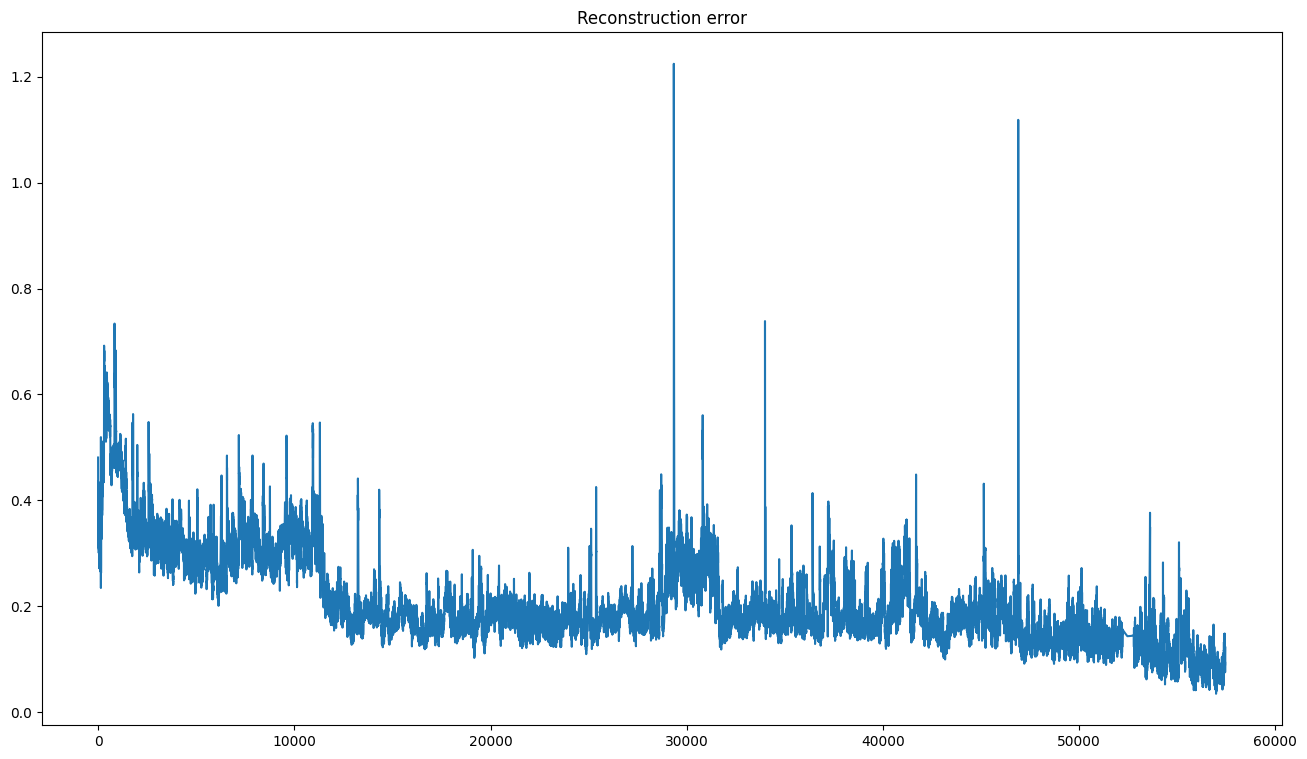

In [75]:
plt.figure(figsize=(16,9))
plt.plot(r_e)
plt.title("Reconstruction error")
plt.show()

In [76]:
print("Max: ", np.max(r_e))
print("Min: ", np.min(r_e))
print("Avg: ", np.mean(r_e))
print("Median: ", np.median(r_e))
print("75%: ", np.percentile(r_e, 75))
print("25%: ", np.percentile(r_e, 25))
print("IQR: ", np.percentile(r_e, 75) - np.percentile(r_e, 25))

Max:  1.2245119287234687
Min:  0.034823246170528996
Avg:  0.20918407488823018
Median:  0.18244629940447674
75%:  0.2521467667071446
25%:  0.15542227628658822
IQR:  0.09672449042055636


## Testing

In [48]:
df_sample_test = pd.read_csv("../../datasets/data_sample_test.csv", index_col="Timestamp")
scaler_test = pickle.load(open('StandardScaler-gearbox.pkl', 'rb'))
df_sample_test_scaled = scaler_test.transform(df_sample_test)

In [49]:
df_sample_test_label = np.where(np.any((df_sample_test_scaled < -3) | (df_sample_test_scaled > 3), axis=1), 1, 0)

In [50]:
df_sample_test_scaled_3d = convert_time_window(df_sample_test_scaled, 10)

In [51]:
generator_encoder = tf.keras.models.load_model("../../models/LSTM-GAN/generator-encoder.h5")
generator_decoder = tf.keras.models.load_model("../../models/LSTM-GAN/generator-decoder.h5")

In [52]:
with tf.device('/GPU:0'):
    Z_test = generator_encoder(df_sample_test_scaled_3d)
# pred_3d_np = generator_decoder(Z_test).numpy()

In [53]:
with tf.device('/GPU:0'):
    pred_3d_np = generator_decoder(Z_test)

In [56]:
pred_2d = inverse_convert_time_window(pred_3d_np.numpy())
# pred_2d_inv = scaler_test.inverse_transform(pred_2d)

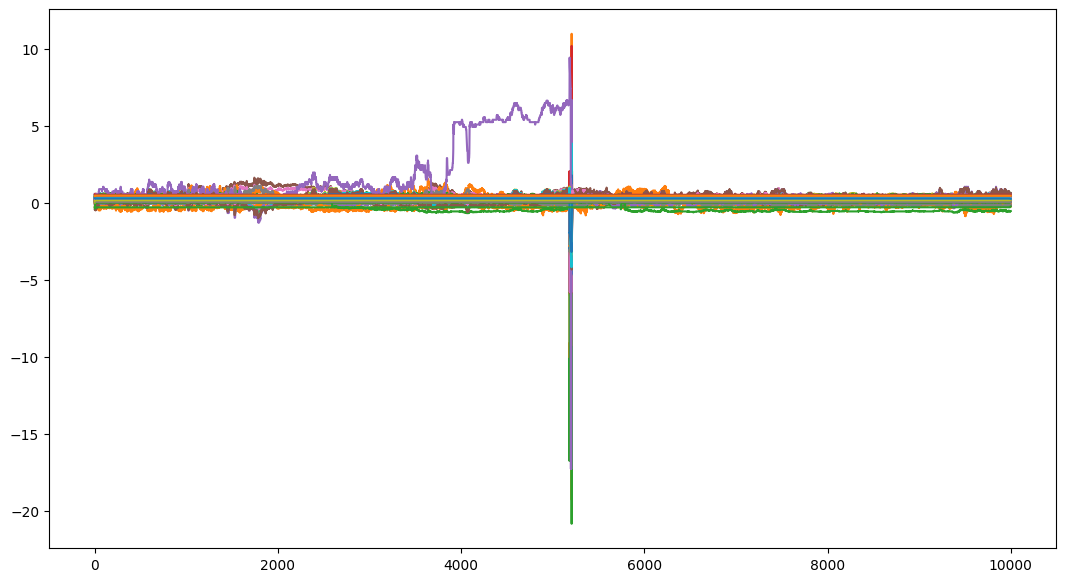

In [57]:
plt.figure(figsize=(13,7))
plt.plot(df_sample_test_scaled)
plt.plot(pred_2d)
# plt.legend(['C1','C2','C3','C1-rec','C2-rec','C3-rec',])
plt.show()

In [59]:
r_e = calculate_reconstruction_loss(df_sample_test_scaled, pred_2d)

In [60]:
thres, f1, y_pred = find_optimal_threshold((r_e), np.array(df_sample_test_label))
print(thres, f1)

0.24637983188220122 0.9814985581713866


In [26]:
# thres, f1, y_pred = find_optimal_threshold((r_e), np.array(merged_data_test_class))
# print(thres, f1)
high_thres = 6.395205856593323
thres = 4.53448285788645
low_thres = 0.504167971928583

if min(r_e) > high_thres:
    y_pred = np.where((r_e > (thres + min(r_e))) ,1, 0)
else:
    y_pred = np.where((r_e > thres) ,1, 0)

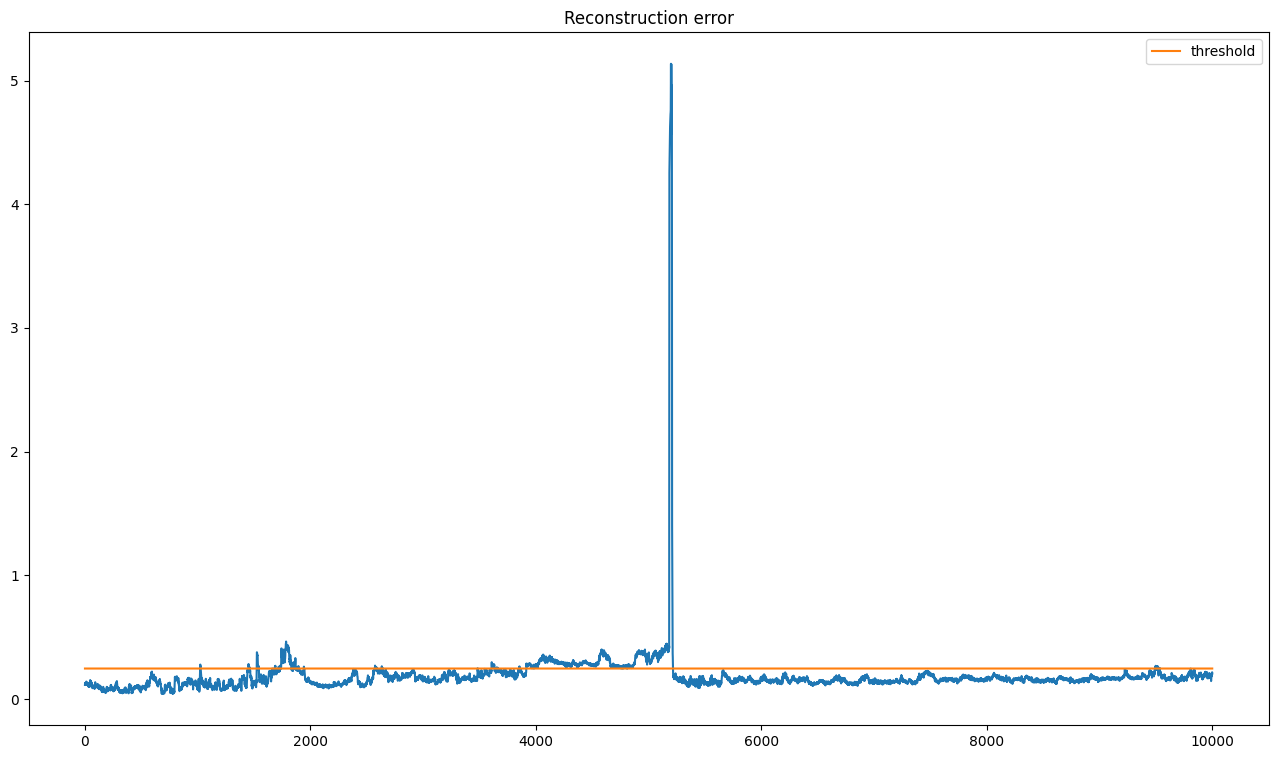

In [61]:
# q3 = np.percentile(r_e, 75)
# q1 = np.percentile(r_e, 25)
# iqr = q3 - q1

plt.figure(figsize=(16,9))
plt.plot(r_e)
plt.plot(np.full(r_e.shape[0], thres), label='threshold')
# xmin, xmax, ymin, ymax = plt.axis()
# plt.fill_betweenx(np.linspace(thres-iqr, thres+iqr, 100), r_e.shape[0], color='blue', alpha=0.3)
plt.title("Reconstruction error")
plt.legend()
plt.show()

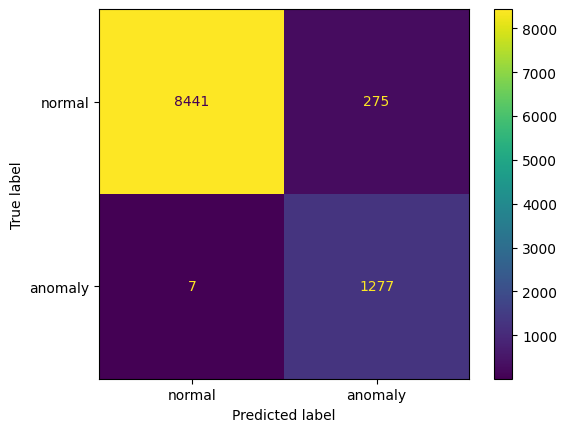

In [64]:
from sklearn import metrics

confusion_matrix = metrics.confusion_matrix(np.array(df_sample_test_label).astype(bool), y_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['normal', 'anomaly'])
cm_display.plot()

In [65]:
print("Accuracy: ", metrics.accuracy_score(np.array(df_sample_test_label).astype(bool), y_pred))
print("F1-score: ", metrics.f1_score(np.array(df_sample_test_label).astype(bool), y_pred))

Accuracy:  0.9718
F1-score:  0.9005641748942173


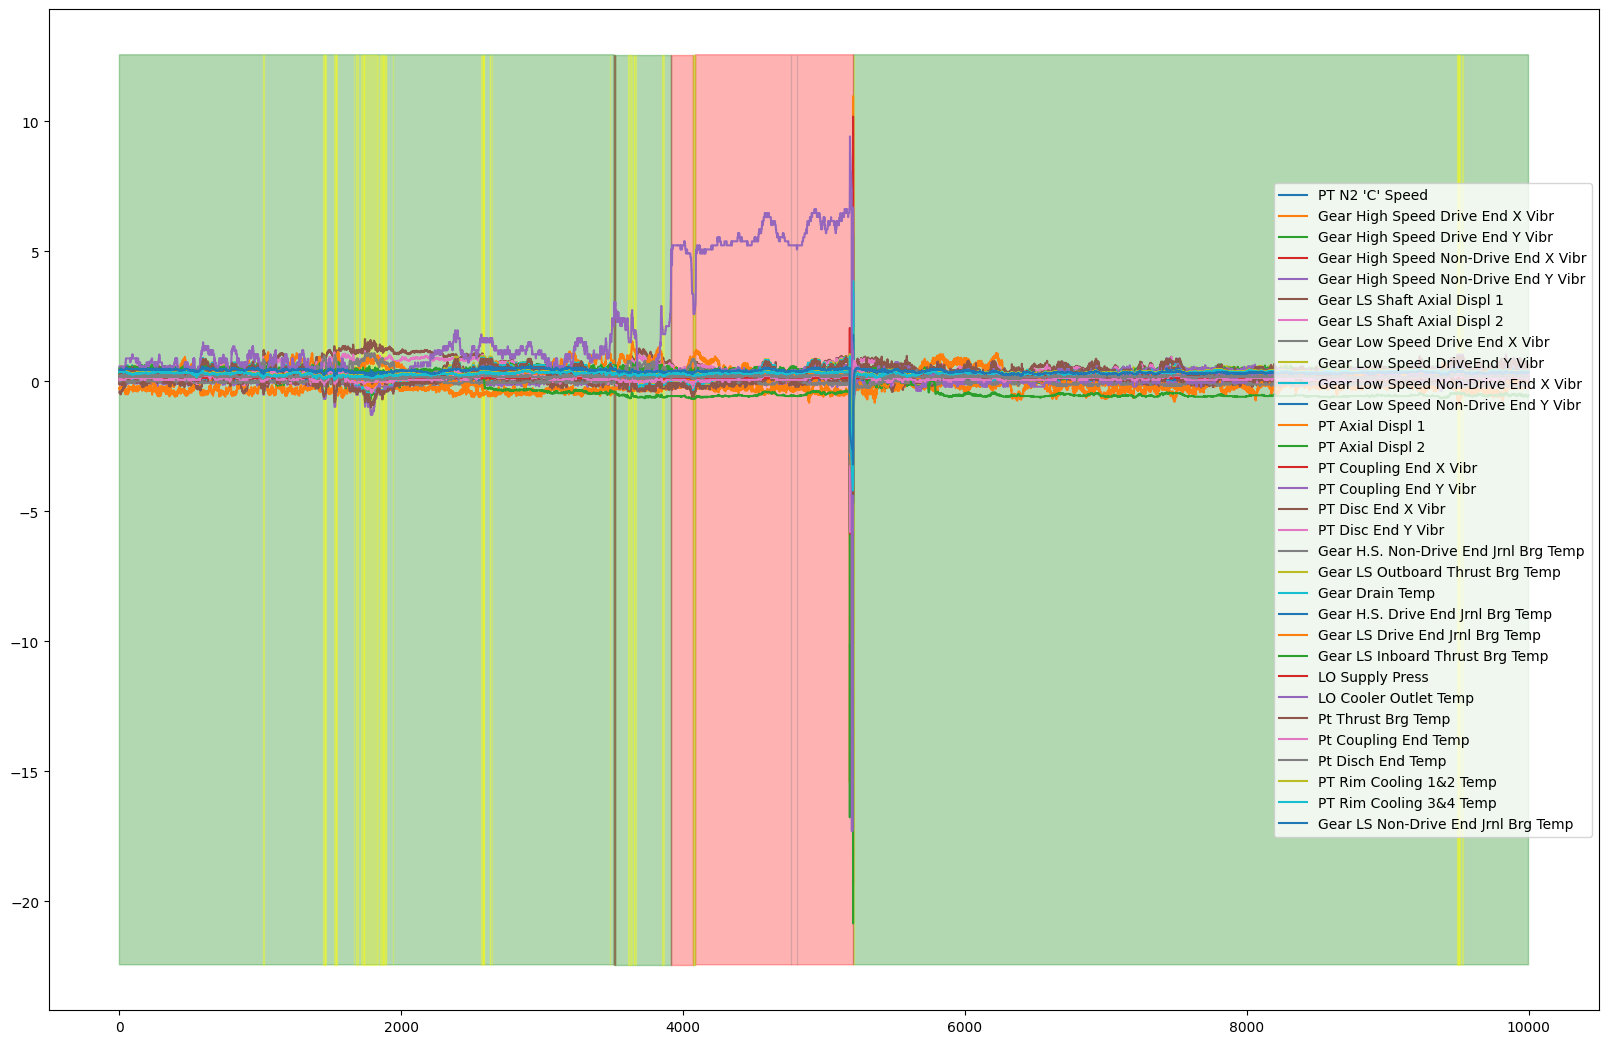

In [63]:
plt.figure(figsize=(20,13))
plt.plot(df_sample_test_scaled)
xmin, xmax, ymin, ymax = plt.axis()
plt.fill_between(np.arange(0, df_sample_test_scaled.shape[0]), ymin, ymax, where=(df_sample_test_label == 0), color='green', alpha=0.3)
plt.fill_between(np.arange(0, df_sample_test_scaled.shape[0]), ymin, ymax, where=(df_sample_test_label == 1), color='red', alpha=0.3)
plt.fill_between(np.arange(0,df_sample_test_scaled.shape[0]), ymin, ymax,where=(~df_sample_test_label.astype(bool) & y_pred ), color='yellow', alpha=0.3)
plt.fill_between(np.arange(0,df_sample_test_scaled.shape[0]), ymin, ymax,where=(df_sample_test_label.astype(bool) & ~y_pred ), color='gray', alpha=0.3)
plt.legend(df_sample_test.columns)
plt.show()

## Smaller sample size testing

In [29]:
sample_test = pd.read_parquet("../../datasets/3W/dataset/1/SIMULATED_00095.parquet")
sample_test = sample_test[['T-TPT','P-TPT', 'P-MON-CKP', 'T-JUS-CKP', 'class']]

# Scale pressure columns (those starting with 'P') by 10^6
pressure_columns = [col for col in sample_test.columns if col.startswith('P')]
sample_test[pressure_columns] = sample_test[pressure_columns] / 10**6   

# sample_test = pd.read_csv('../../datasets/3W/dataset_processed/csv/2/WELL-00011_20141006150121.csv', index_col='timestamp')
# sample_test.dropna(inplace=True)
sample_test['class'].fillna(value=0, inplace=True) 
sample_test_class = sample_test['class']
sample_test_np = sample_test.drop('class',axis=1).values

<Axes: xlabel='timestamp'>

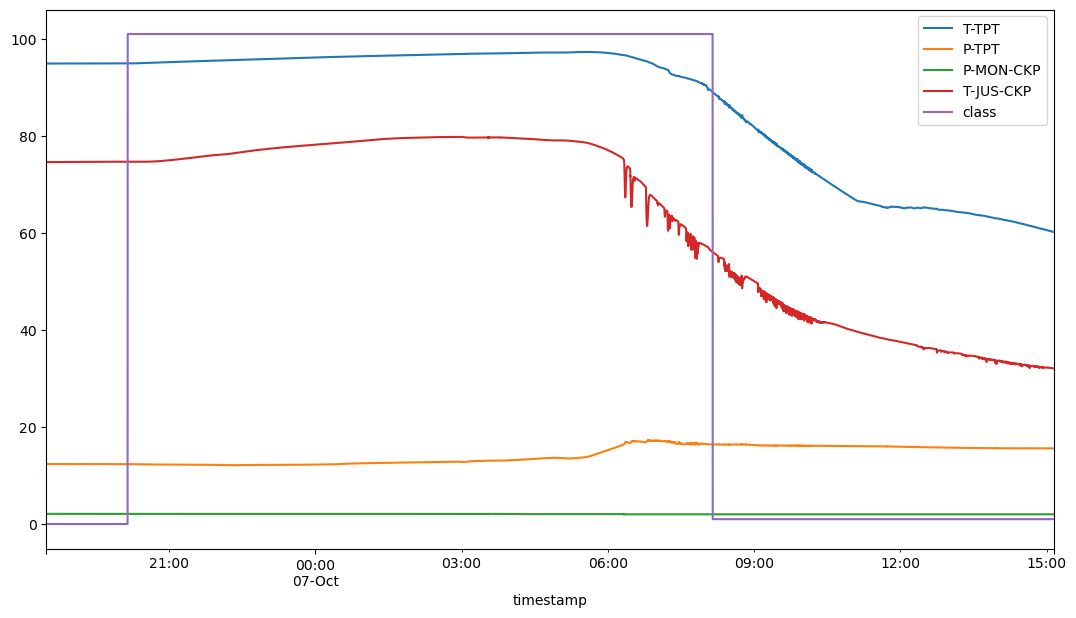

In [30]:
sample_test.plot(figsize=(13,7))

In [31]:
# scaler_test = pickle.load(open('StandardScaler-3W-2.pkl', 'rb'))
# sample_test_np_scaled = scaler_test.transform(sample_test_np)
sample_test_np_3d = convert_time_window(sample_test_np, 10)

In [15]:
generator_encoder = tf.keras.models.load_model("../../models/3W/LSTM-GAN/train-filtered/5/generator-encoder-22-9-2024.h5")
generator_decoder = tf.keras.models.load_model("../../models/3W/LSTM-GAN/train-filtered/5/generator-decoder-22-9-2024.h5")

2024-09-24 22:03:45.387338: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


In [32]:
with tf.device('/CPU:0'):
    Z_test = generator_encoder(sample_test_np_3d)
    pred_3d_np = generator_decoder(Z_test).numpy()

In [33]:
pred_2d = inverse_convert_time_window(pred_3d_np)

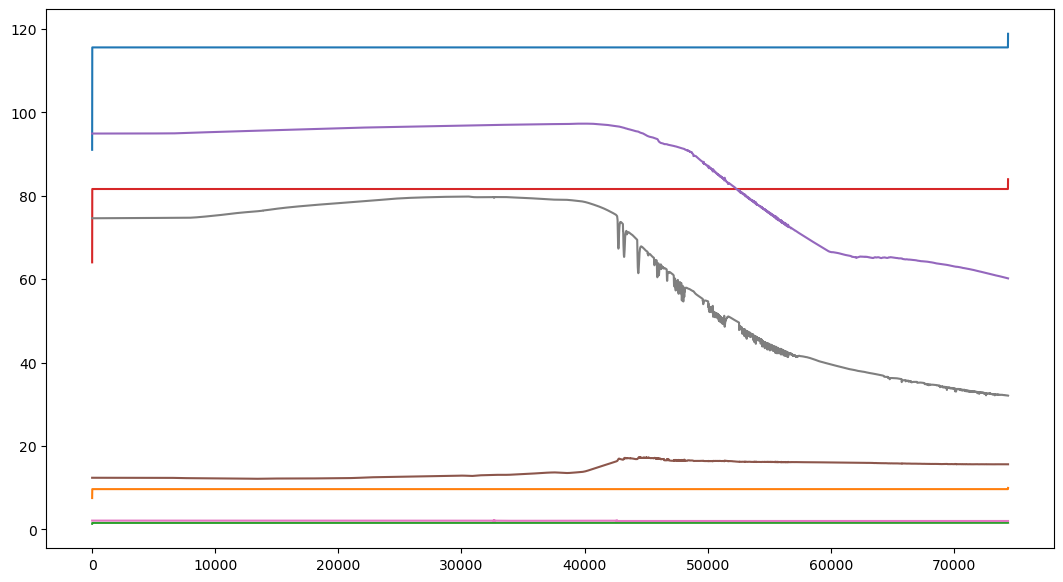

In [34]:
plt.figure(figsize=(13,7))
plt.plot(pred_2d)
plt.plot(sample_test_np)
plt.show()

In [35]:
sample_r_e = calculate_reconstruction_loss(sample_test_np, pred_2d)

In [129]:
thres, f1, sample_y_pred  = find_optimal_threshold(r_e, sample_test_class)
print(thres, f1)

0.0005656278466124395 0.9968054453219043


In [36]:
high_thres = 6.395205856593323
thres = 4.53448285788645
low_thres = 0.504167971928583

if np.min(sample_r_e[1:]) > high_thres:
    sample_y_pred = np.where((sample_r_e > (thres + np.min(sample_r_e[1:]))) ,1, 0)
else:
    sample_y_pred = np.where((sample_r_e > thres) ,1, 0)

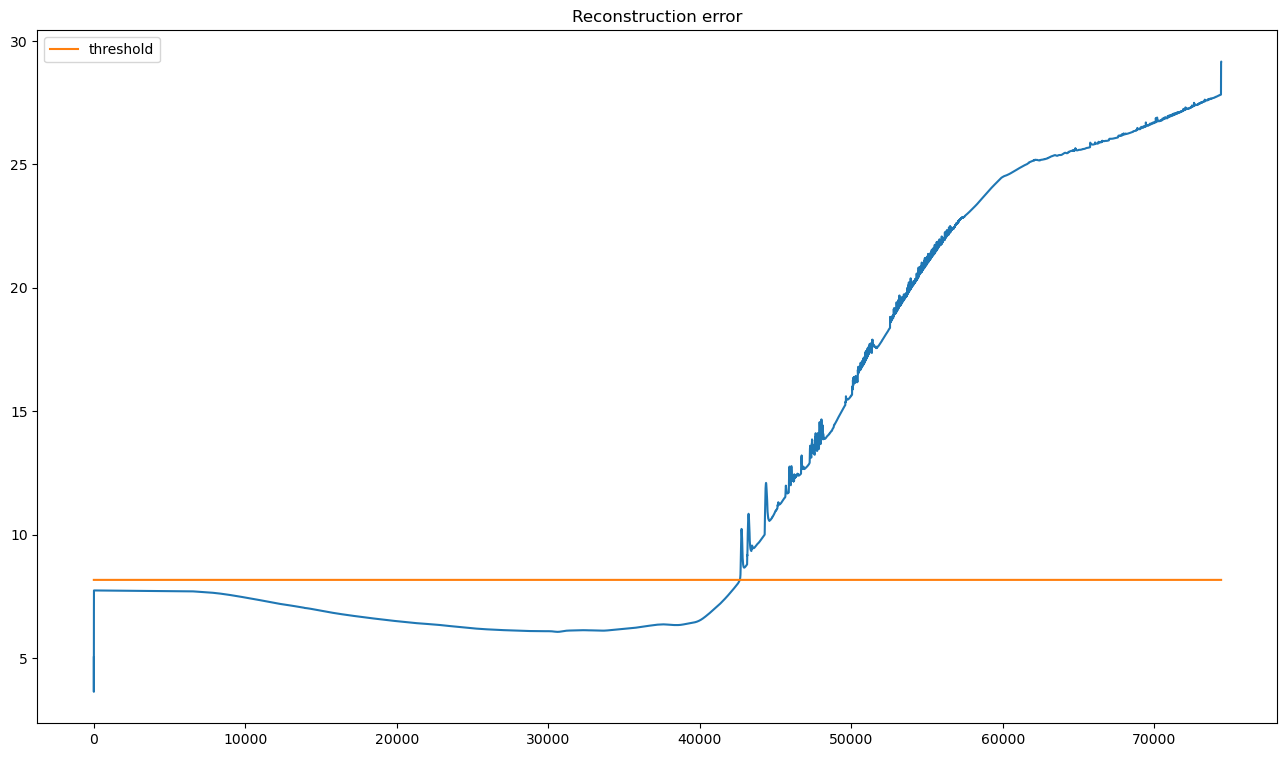

In [37]:
# q3 = np.percentile(sample_r_e, 75)
# q1 = np.percentile(sample_r_e, 25)
# iqr = q3 - q1

plt.figure(figsize=(16,9))
plt.plot(sample_r_e)
plt.plot(np.full(sample_r_e.shape[0], thres + np.min(sample_r_e[1:])), label='threshold')
# xmin, xmax, ymin, ymax = plt.axis()
# plt.fill_betweenx(np.linspace(thres-iqr, thres+iqr, 100), sample_r_e.shape[0], color='blue', alpha=0.3)
plt.title("Reconstruction error")
plt.legend()
plt.show()

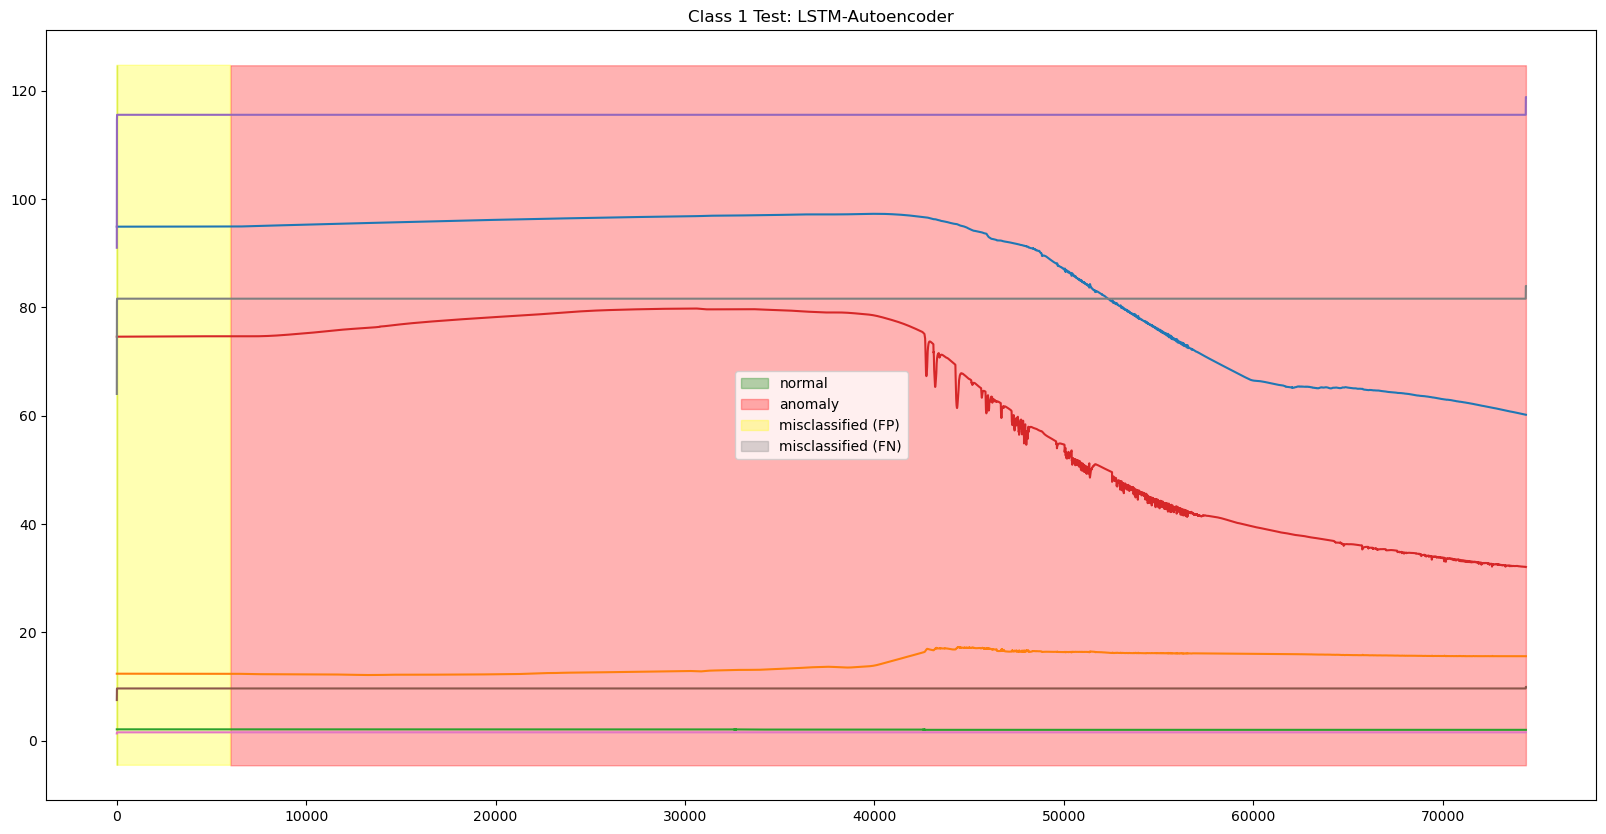

In [38]:
plt.figure(figsize=(20,10))
plt.plot(sample_test_np)
plt.plot(pred_2d)
xmin, xmax, ymin, ymax = plt.axis()
plt.fill_between(np.arange(0,len(pred_2d)), ymax, ymin, where=((~sample_test_class.astype(bool)) & (~sample_y_pred)), color='green', alpha=0.3, label='normal')
plt.fill_between(np.arange(0,len(pred_2d)), ymax, ymin,where=((sample_test_class.astype(bool)) & (sample_y_pred)), color='red', alpha=0.3, label='anomaly')
plt.fill_between(np.arange(0,len(pred_2d)), ymax, ymin,where=(~sample_test_class.astype(bool) & sample_y_pred ), color='yellow', alpha=0.3, label='misclassified (FP)')
plt.fill_between(np.arange(0,len(pred_2d)), ymax, ymin,where=(sample_test_class.astype(bool) & ~sample_y_pred ), color='gray', alpha=0.3, label='misclassified (FN)')
# plt.legend(['P-PDG','P-TPT', 'T-TPT','P-PDG_rec','P-TPT_rec', 'T-TPT_rec','normal','anomaly','missclasiffied [FP]','missclasiffied [FN]'])
plt.legend()
plt.title("Class 1 Test: LSTM-Autoencoder")
plt.show()

In [37]:
print("Accuracy: ", metrics.accuracy_score(np.array(sample_test_class).astype(bool), sample_y_pred))
print("F1-score: ", metrics.f1_score(np.array(sample_test_class).astype(bool), sample_y_pred))

Accuracy:  0.5814863102998696
F1-score:  0.7353443659637402


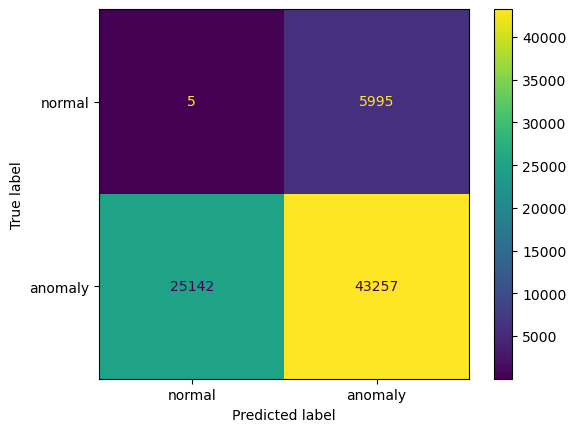

In [36]:
from sklearn import metrics

confusion_matrix = metrics.confusion_matrix(np.array(sample_test_class).astype(bool), sample_y_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['normal', 'anomaly'])
cm_display.plot()

In [21]:
gener = keras.models.load_model("generator_lstm_gan_10.h5")

In [22]:
merged_df_test = get_dataset('dataset_processed/splitted/2/test')
merged_data_test_class = merged_df_test['class']

merged_data_test_np = merged_df_test.drop('class', axis=1).values

In [27]:
scaler_test = pickle.load(open('StandardScaler.pkl', 'rb'))
merged_data_test_np_scaled = scaler_test.transform(merged_data_test_np)
merged_data_test_np_3d = convert_time_window(merged_data_test_np, 10)

In [28]:
test_data = merged_data_test_np_3d
fake_data = gener.predict(test_data)


3439/3439 [==============================] - 15s 4ms/step


In [31]:
fake_data_2d = inverse_convert_time_window(fake_data)

In [41]:
scalerrr = sklearn.preprocessing.StandardScaler()
fake_data_2d_scaled = scalerrr.fit_transform(fake_data_2d)

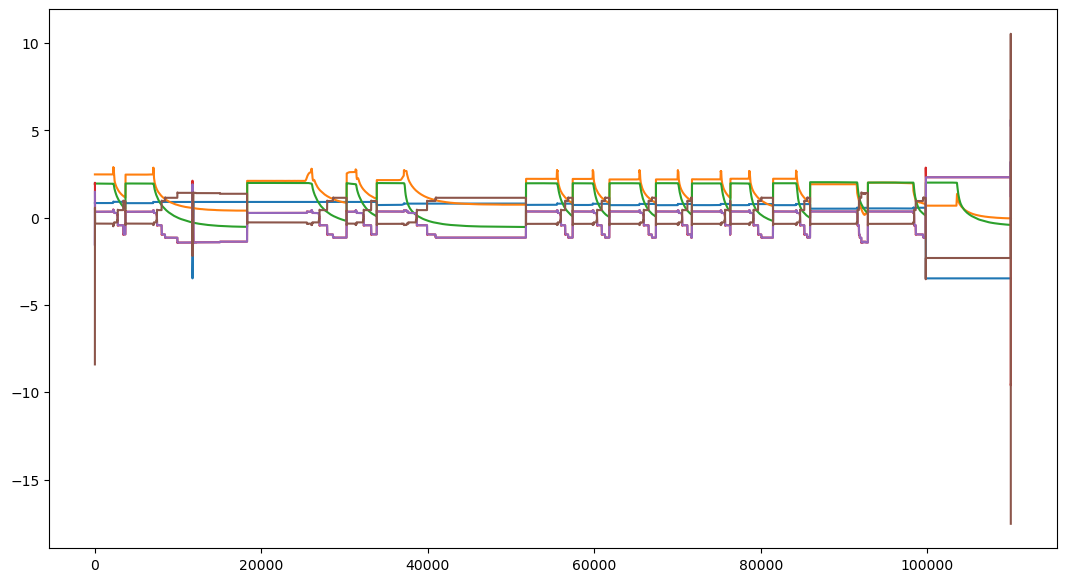

In [44]:
plt.figure(figsize=(13,7))
plt.plot(merged_data_test_np_scaled)
plt.plot(fake_data_2d_scaled)
plt.show()

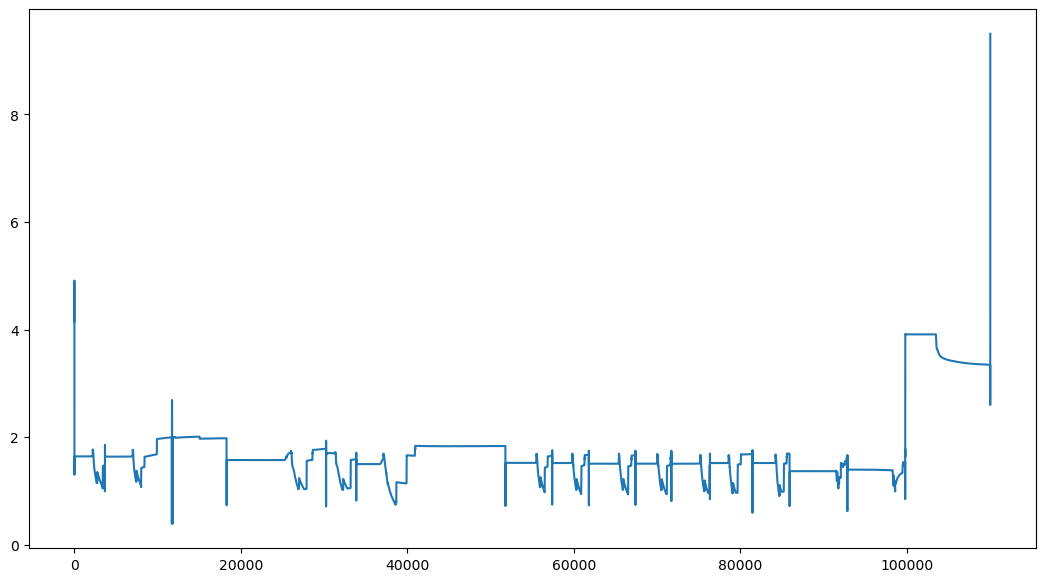

In [46]:
r_e = calculate_reconstruction_loss(merged_data_test_np_scaled, fake_data_2d_scaled)

plt.figure(figsize=(13,7))
plt.plot(r_e)
# plt.plot(fake_data_2d_scaled)
plt.show()

In [28]:

# Latent space reconstruction loss
latent_real = generator(test_data)
latent_fake = generator(fake_data)

anomaly_score = np.mean(np.square(latent_real - latent_fake), axis=1)


In [ ]:

# Evaluate the model (replace `true_labels` with actual labels)
true_labels = np.random.randint(0, 4, size=1000)
evaluate_model(train_data, true_labels, thresholds=[0.2, 0.5, 0.7])